<a href="https://colab.research.google.com/github/sukhyun1017/NLP-study/blob/main/7_NLP_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문서 벡터로 추천 시스템

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [3]:
df[:5]

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [ ]:
#아스키 번호로 문자 삭제
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# re.compile() : 정규표현식 저장하기 / html 기호 제거.?
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

#토큰화 : token 으로 쪼개기
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text) #리스트 안에 토큰화 됨
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [14]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [15]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


In [16]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

pre-trained 워드 임베딩 사용

In [17]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

In [18]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [19]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


문서 벡터의 수 : 2381


In [21]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [23]:
df[['title', 'image_link']][:5]

,title,image_link
0,The End of Power: From Boardrooms to Battlefie...,https://i.gr-assets.com/images/S/compressed.ph...
1,"Console Wars: Sega, Nintendo, and the Battle t...",https://i.gr-assets.com/images/S/compressed.ph...
2,Trust Agents: Using the Web to Build Influence...,https://i.gr-assets.com/images/S/compressed.ph...
3,The Four Pillars of Investing,https://i.gr-assets.com/images/S/compressed.ph...
4,Made in Japan: Akio Morita and Sony,https://i.gr-assets.com/images/S/compressed.ph...


In [31]:
pd.Series(['a','b','c','d'],index=["1",'2','3','4']).drop_duplicates()

1    a
2    b
3    c
4    d
dtype: object

In [32]:
list(enumerate([1,2,3]))

[(0, 1), (1, 2), (2, 3)]

In [46]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장. / drop_duplicates() : 중복값 삭제
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]
    
    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True) #내림차순
    sim_scores = sim_scores[0:6] # sim_scores[0] 은 자기 자신임
    print(sim_scores)
    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    #.reset_index(drop = True): 기존의 행 인덱스를 제거하고 0부터 다시 시작
    recommend = books.iloc[book_indices].reset_index(drop=True)
    print(recommend)
    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    # iterrows(): 각 행의 데이터가 (인덱스, Series)로 만들어져 할당됩니다.
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 6, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

[(1191, 0.99999976), (1286, 0.8832129), (1582, 0.87232745), (1437, 0.8644548), (1216, 0.8616229), (1944, 0.8605284)]
                           title  \
0              The Da Vinci Code   
1                The Lost Symbol   
2                         Origin   
3  Jonathan Strange & Mr Norrell   
4                Angels & Demons   
5                The Miniaturist   

                                          image_link  
0  https://i.gr-assets.com/images/S/compressed.ph...  
1  https://i.gr-assets.com/images/S/compressed.ph...  
2  https://i.gr-assets.com/images/S/compressed.ph...  
3  https://i.gr-assets.com/images/S/compressed.ph...  
4  https://i.gr-assets.com/images/S/compressed.ph...  
5  https://i.gr-assets.com/images/S/compressed.ph...  


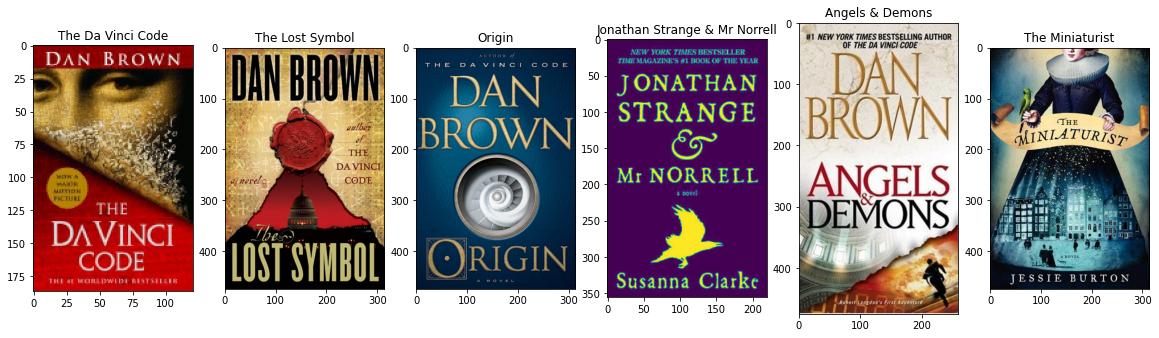

In [47]:
recommendations("The Da Vinci Code")

[(1866, 0.9999998), (2008, 0.87501436), (1406, 0.8685983), (2114, 0.86635673), (2092, 0.8640351), (1796, 0.86114526)]
                         title  \
0  The Murder of Roger Ackroyd   
1                   Night Film   
2         The Cuckoo's Calling   
3                 Mystic River   
4               Case Histories   
5                 Mr. Mercedes   

                                          image_link  
0  https://i.gr-assets.com/images/S/compressed.ph...  
1  https://i.gr-assets.com/images/S/compressed.ph...  
2  https://i.gr-assets.com/images/S/compressed.ph...  
3  https://i.gr-assets.com/images/S/compressed.ph...  
4  https://i.gr-assets.com/images/S/compressed.ph...  
5  https://i.gr-assets.com/images/S/compressed.ph...  


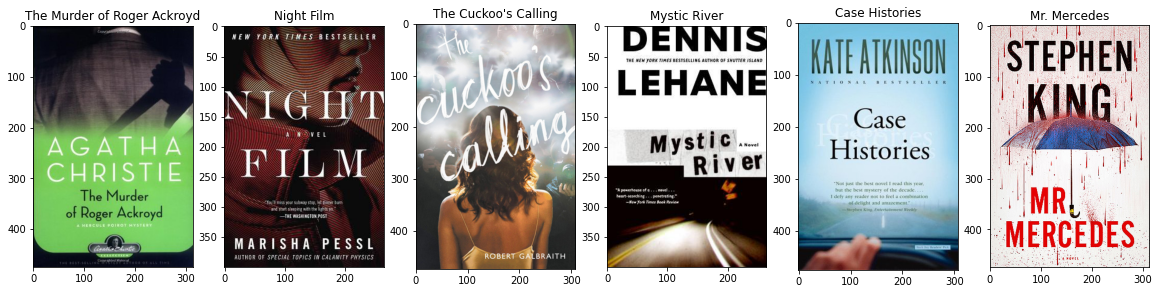

In [48]:
recommendations("The Murder of Roger Ackroyd")